 ## Experiments on a notion of variance explained for networks

 ## A notion of variance explained for a stochastic block model
 Let $A$ be the $n \times n$ adjacency matrix for a loopless, unweighted network (can be directed or
 undirected). Let $P$ be a $n \times n$ matrix of probabilities for any potential edge occuring,
 under any model where
 $$
  A \sim Bernoulli(P)
 $$
 with each edge sampled independently.


 Define:
 $$
  \nu(A, \tau) = 1 - \frac{\| A - \hat{P}_{SBM}(A,\tau)\|_F^2}{\|A\|_F^2}
 $$

 where $\hat{P}_{SBM}(A, \tau)$ is the probability matrix estimate induced by the stochastic
 block model under some partition $\tau$.

In [1]:
import graspologic as gl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.plot import set_theme

set_theme()


def stashfig(
    name,
    format="png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
    transparent=False,
    facecolor="white",
    **kws,
):
    plt.savefig(
        "sandbox/results/var_explained_for_carey/" + name + f".{format}",
        format=format,
        dpi=dpi,
        bbox_inches=bbox_inches,
        transparent=transparent,
        pad_inches=pad_inches,
        facecolor=facecolor,
    )

 ## Questions
 We are interested in several questions for how this metric performs on simulated data.
 "so ... what does this do:"

 1. when A is an SBM and $\tau$ are given true block memberships?
 2. when A is an SBM and $\tau$ are given errorful block memberships?
 3. when A is a general RDPG and $\tau$ are given wholecloth block memberships?


 Questions 1 and 2 are investigated in Simulation 1, Question 3 is investigated in Simulation 2.


 ## Simulation 1

 ### The model
 A is an SBM with 4-blocks, 50 nodes per block (n=200). The block probability matrix is shown
 below.

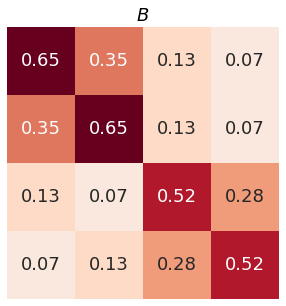

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
base_B = np.array(
    [
        [0.5, 0.5, 0.1, 0.1],
        [0.5, 0.5, 0.1, 0.1],
        [0.1, 0.1, 0.4, 0.4],
        [0.1, 0.1, 0.4, 0.4],
    ]
)

perturb_B = np.array(
    [
        [0.05, -0.05, 0.01, -0.01],
        [-0.05, 0.05, 0.01, -0.01],
        [0.01, -0.01, 0.04, -0.04],
        [-0.01, 0.01, -0.04, 0.04],
    ]
)
heatmap_kws = dict(
    cmap="RdBu_r",
    center=0,
    cbar=False,
    annot=True,
    square=True,
    xticklabels=False,
    yticklabels=False,
)
sns.heatmap(base_B + 3 * perturb_B, ax=ax, **heatmap_kws)
ax.set(title=r"$B$")

stashfig("model-explanation")


 ### The experiment
 This experiment looks at the performance of this variance explained metric as a function
 of increasingly corrupted labels. For an increasing proportion $p$ of the labels, some
 proportion of the true SBM labels $\tau$ are randomly shuffled. This new partition $\tau_{shuffled}(p)$
 is then used to fit a stochastic block model, generating $\hat{P}_{SBM}(A, \tau_{shuffled}(p))$.
 $\nu(A, \tau)$ is then plotted as a function of $p$.

 In addition, $\nu(A, \tau)$ is also plotted for the Erdos-Reyni model, that is, $\tau$
 corresponding to all nodes in the same block.

 This experiment is performed 100 times for each value of $p$, resampling a new network
 at each trial.

In [3]:
n_per_leaf_comm = 50

lvl1_labels = np.array(2 * n_per_leaf_comm * [0] + 2 * n_per_leaf_comm * [1])

n_per_comm = 4 * [n_per_leaf_comm]

alpha = 3
n_trials = 100
composite_B = base_B + alpha * perturb_B

rows = []
props = np.linspace(0, 1, num=5)
for prop in props:
    for trial in range(n_trials):

        A, lvl2_labels = gl.simulations.sbm(
            n_per_comm, composite_B, return_labels=True, directed=True
        )

        n_shuffle = int(prop * len(lvl2_labels))
        inds_to_shuffle = np.random.choice(
            len(lvl2_labels), size=n_shuffle, replace=False
        )
        shuffle_inds = np.random.permutation(len(inds_to_shuffle))

        lvl2_labels[inds_to_shuffle] = lvl2_labels[inds_to_shuffle][shuffle_inds]

        sbm = gl.models.SBMEstimator(directed=True, loops=False)
        sbm.fit(A, y=lvl2_labels)
        #         log_lik = sbm.score(A)
        p_mat = sbm.p_mat_
        diff = A - p_mat
        exp = 1 - np.linalg.norm(diff) ** 2 / np.linalg.norm(A) ** 2
        rows.append(
            {
                "trial": trial,
                "alpha": alpha,
                "exp": exp,
                "partition": "Level 2",
                "prop": prop,
            }
        )

for trial in range(n_trials):
    A, lvl2_labels = gl.simulations.sbm(
        n_per_comm, composite_B, return_labels=True, directed=True
    )

    n_shuffle = int(prop * len(lvl2_labels))
    inds_to_shuffle = np.random.choice(len(lvl2_labels), size=n_shuffle, replace=False)
    shuffle_inds = np.random.permutation(len(inds_to_shuffle))

    lvl2_labels[inds_to_shuffle] = lvl2_labels[inds_to_shuffle][shuffle_inds]

    sbm = gl.models.EREstimator(directed=True, loops=False)
    sbm.fit(A)
    p_mat = sbm.p_mat_
    diff = A - p_mat
    exp = 1 - np.linalg.norm(diff) ** 2 / np.linalg.norm(A) ** 2
    rows.append(
        {
            "trial": trial,
            "alpha": alpha,
            "exp": exp,
            "partition": "ER",
            "prop": "ER",
        }
    )

results = pd.DataFrame(rows)


 ### The results

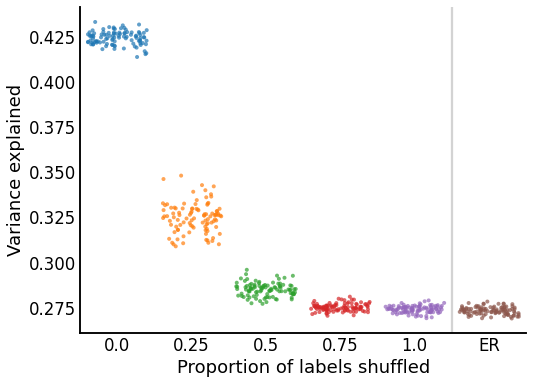

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.stripplot(data=results, x="prop", y="exp", alpha=0.7, jitter=0.4, s=4, ax=ax)
ax.set(ylabel="Variance explained", xlabel="Proportion of labels shuffled")
ax.axvline(4.5, color="lightgrey")


 ## Simulation 2

 ### The model
 Here, $A \sim RDPG(X)$, that is $A$ is no longer from an SBM model. $n$ is 200 nodes. $X$ is generated
 from the Hardy-Weinberg curve - here I use:
 $$
 \theta \sim Uniform(0.2, 0.8)
 $$
 $$
 X \sim HW(\theta)
 $$
 with each $\theta$ sampled i.i.d.

 Then,
 $$
 A \sim RDPG(X)
 $$

 ### The experiment
 Here I look at what happens when we use "fake" labels that have nothing to do with the
 RDPG structure above. I use a $\tau$ where each node is randomly assigned to one of
 four blocks, and each block has 50 members. Again, this partition is used to calculate
 $\nu(A, \tau)$. I also compute the same for $\tau$ corresponding to the Erdos-Reyni
 model as explained above.

In [5]:


def hardy_weinberg(theta):
    """
    Maps a value from [0, 1] to the hardy weinberg curve.
    """
    hw = [theta ** 2, 2 * theta * (1 - theta), (1 - theta) ** 2]
    return np.array(hw).T


n = 200
n_trials = 100

base_labels = 50 * [0] + 50 * [1] + 50 * [2] + 50 * [3]
base_labels = np.array(base_labels)
rows = []
for trial in range(n_trials):
    thetas = np.random.uniform(0.2, 0.8, size=n)
    X = hardy_weinberg(thetas)
    A = gl.simulations.rdpg(X, loops=False, directed=True)
    labels = base_labels.copy()
    np.random.shuffle(labels)  # seems unnecessary, but just in case

    sbm = gl.models.SBMEstimator(directed=True, loops=False)
    sbm.fit(A, y=labels)

    p_mat = sbm.p_mat_
    diff = A - p_mat
    exp = 1 - np.linalg.norm(diff) ** 2 / np.linalg.norm(A) ** 2
    rows.append(
        {
            "trial": trial,
            "exp": exp,
            "partition": "Random (4 block)",
        }
    )


for trial in range(n_trials):
    thetas = np.random.uniform(0.2, 0.8, size=n)
    X = hardy_weinberg(thetas)
    A = gl.simulations.rdpg(X, loops=False, directed=True)

    sbm = gl.models.EREstimator(directed=True, loops=False)
    sbm.fit(A)
    p_mat = sbm.p_mat_
    diff = A - p_mat
    exp = 1 - np.linalg.norm(diff) ** 2 / np.linalg.norm(A) ** 2
    rows.append(
        {
            "trial": trial,
            "alpha": alpha,
            "exp": exp,
            "partition": "ER",
            "prop": "ER",
        }
    )

rdpg_results = pd.DataFrame(rows)


 ### The results

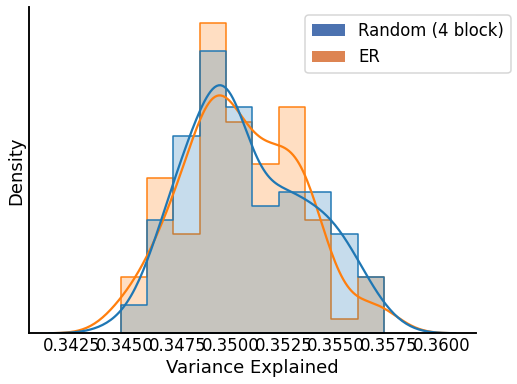

In [6]:
colors = sns.color_palette("deep", 2)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(
    data=rdpg_results, x="exp", hue="partition", stat="density", element="step"
)
sns.kdeplot(data=rdpg_results, x="exp", hue="partition")
ax.set(xlabel="Variance Explained", yticks=[])

import matplotlib.patches as mpatches
handles = [
    mpatches.Patch(facecolor=colors[0], label="Random (4 block)"),
    mpatches.Patch(facecolor=colors[1], label="ER"),
]
ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(0.6, 1))
